In [46]:
import pandas as pd

In [47]:
# 1) Load the CSV ─ change the filename as needed
df = pd.read_csv("reviewer_ratings.csv")

In [48]:
# 2) Pick out the numeric score columns
score_cols = [c for c in df.columns if ("Graph" in c) or ("LLM" in c)]
scores     = df[score_cols].apply(pd.to_numeric, errors="coerce")

In [49]:
# 3) Row-wise z-score
row_mean = scores.mean(axis=1)
row_std  = scores.std(axis=1)
z_scores = scores.sub(row_mean, axis=0).div(row_std, axis=0)

In [50]:
# 4) Build a new dataframe that keeps the reviewer ID plus the z-scores
z_df = pd.concat([df.drop(columns=score_cols), z_scores], axis=1)

In [51]:
# 5) Get the mean z-score for every Question×Model column
mean_z = z_scores.mean()           # Series indexed by column name
mean_df = mean_z.reset_index()     # tidy 2-column dataframe
mean_df.columns = ["Question_Model", "Mean_z"]

In [52]:
mean_df

,Question_Model,Mean_z
0,Q1_Quality_Graph,0.643250
1,Q1_Quality_LLM,-1.174212
2,Q1_Trust_Graph,0.488371
3,Q1_Trust_LLM,-1.351481
4,Q2_Quality_Graph,0.706050
5,Q2_Quality_LLM,-0.279952
6,Q2_Trust_Graph,0.607635
7,Q2_Trust_LLM,-0.290771
8,Q3_Quality_Graph,0.382762
9,Q3_Quality_LLM,-0.252085


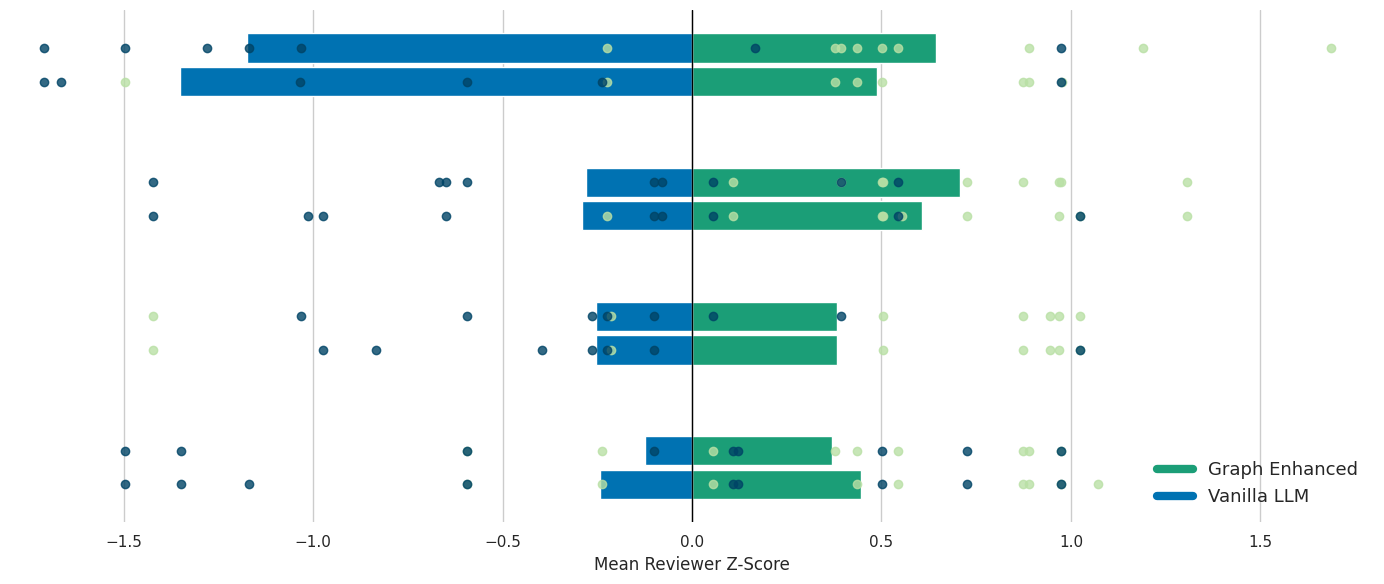

In [53]:
# ────────────────────────────────────────────────────────────────
#  PLOT MEAN_DF WITH REVIEWER DOTS FROM Z_DF
# ────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1) Mean z-score pivot
tmp = mean_df.copy()
tmp[["QID", "Metric", "Method"]] = tmp["Question_Model"].str.split("_", expand=True)
task_lookup = {
    "Q1": "Retrieve - ULMOF WS",
    "Q2": "Infer - Metal",
    "Q3": "Infer - WS",
    "Q4": "Retrieve - Similarity",
}
tmp["Task"] = tmp["QID"].map(task_lookup)
pivot = tmp.pivot_table(index=["Task", "Metric"], columns="Method", values="Mean_z")

# 2) Melt z_df to long format for dot overlay
z_long = z_df.melt(id_vars=["Reviewer"], var_name="Question_Model", value_name="Z")
z_long[["QID", "Metric", "Method"]] = z_long["Question_Model"].str.split("_", expand=True)
z_long["Task"] = z_long["QID"].map(task_lookup)

# 3) Layout settings
task_order   = ["Retrieve - ULMOF WS", "Infer - Metal", "Infer - WS", "Retrieve - Similarity"]
metric_order = ["Quality", "Trust"]
bar_h, within_gap, between_gap = .35, .05, .80
blue, red = "#1B9E77", "#0072B2"
dot_blue, dot_red = "#B9E0A5", "#004466"
dot_size = 6

labels, yvals, g_vals, l_vals, dot_coords = [], [], [], [], []
y = 0
for task in task_order:
    for metric in metric_order:
        if (task, metric) in pivot.index:
            labels.append(f"{task} | {metric}")
            yvals.append(y)
            g_vals.append(pivot.loc[(task, metric), "Graph"])
            l_vals.append(pivot.loc[(task, metric), "LLM"])
            # Dots: extract z-scores for this task/metric
            dots_graph = z_long.query("Task == @task and Metric == @metric and Method == 'Graph'")
            dots_llm   = z_long.query("Task == @task and Metric == @metric and Method == 'LLM'")
            for _, row in dots_graph.iterrows():
                dot_coords.append((row["Z"], y, dot_blue))
            for _, row in dots_llm.iterrows():
                dot_coords.append((row["Z"], y, dot_red))
            y += bar_h + within_gap
    y += between_gap

# 4) Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.axvline(0, color="black", linewidth=1)

for y0, gv, lv in zip(yvals, g_vals, l_vals):
    ax.barh(y0,  gv, height=bar_h, color=blue)
    ax.barh(y0,  lv, height=bar_h, color=red)

for x, y0, c in dot_coords:
    ax.plot(x, y0, 'o', color=c, markersize=dot_size, alpha=0.8)

# Cosmetics
ax.set_yticks([])           # no ticks
ax.set_yticklabels([])      # no labels
ax.tick_params(left=False)  # no tick lines
ax.set_xlabel("Mean Reviewer Z-Score", fontsize=12)
ax.set_xlim(-1.8, 1.8)
ax.invert_yaxis()
sns.despine(left=True, bottom=True)

# Legend (bars only, larger font)
ax.legend(
    handles=[
        Line2D([0], [0], lw=6, color=blue, label="Graph Enhanced"),
        Line2D([0], [0], lw=6, color=red,  label="Vanilla LLM")
    ],
    frameon=False,
    loc="lower right",
    fontsize=13  # Slightly larger than default
)



plt.tight_layout(); plt.show()

fig.savefig("figure.svg", format="svg", bbox_inches="tight")


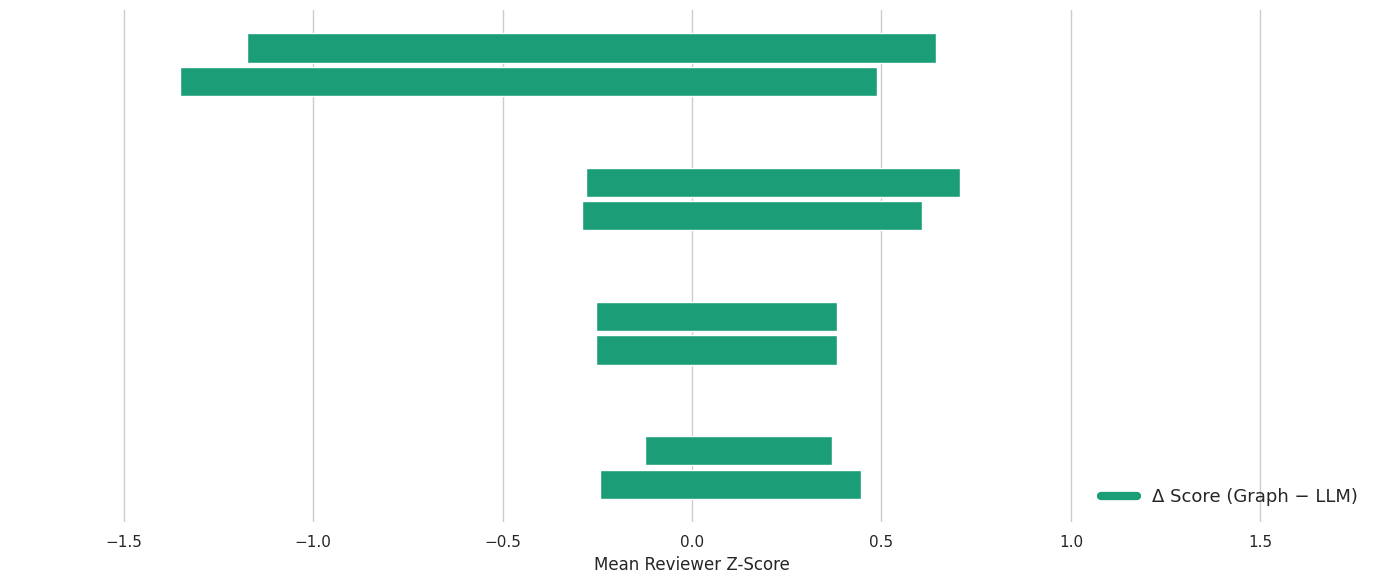

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# ────────────────────────────────────────────────────────────────
#  PLOT DELTA SPAN BAR: Graph vs LLM (No Dots, Clean Legend)
# ────────────────────────────────────────────────────────────────

# 1) Mean z-score pivot
tmp = mean_df.copy()
tmp[["QID", "Metric", "Method"]] = tmp["Question_Model"].str.split("_", expand=True)
task_lookup = {
    "Q1": "Retrieve - ULMOF WS",
    "Q2": "Infer - Metal",
    "Q3": "Infer - WS",
    "Q4": "Retrieve - Similarity",
}
tmp["Task"] = tmp["QID"].map(task_lookup)
pivot = tmp.pivot_table(index=["Task", "Metric"], columns="Method", values="Mean_z")

# 2) Layout setup
task_order   = ["Retrieve - ULMOF WS", "Infer - Metal", "Infer - WS", "Retrieve - Similarity"]
metric_order = ["Quality", "Trust"]
bar_h, within_gap, between_gap = .35, .05, .80
green = "#1B9E77"

labels, yvals, start_vals, widths = [], [], [], []
y = 0
for task in task_order:
    for metric in metric_order:
        if (task, metric) in pivot.index:
            labels.append(f"{task} | {metric}")
            yvals.append(y)

            llm_val = pivot.loc[(task, metric), "LLM"]
            graph_val = pivot.loc[(task, metric), "Graph"]
            start = min(llm_val, graph_val)
            width = abs(graph_val - llm_val)
            start_vals.append(start)
            widths.append(width)

            y += bar_h + within_gap
    y += between_gap

# 3) Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each span bar
for y0, start, width in zip(yvals, start_vals, widths):
    ax.barh(y0, width, height=bar_h, left=start, color=green)

# Formatting
ax.set_yticks([])           # Hide y-axis ticks
ax.set_yticklabels([])      # Hide y-axis labels
ax.tick_params(left=False)  # Remove y tick lines
ax.set_xlabel("Mean Reviewer Z-Score", fontsize=12)
ax.set_xlim(-1.8, 1.8)
ax.invert_yaxis()
sns.despine(left=True, bottom=True)

# Clean Legend
ax.legend(
    handles=[
        Line2D([0], [0], lw=6, color=green, label="Δ Score (Graph − LLM)")
    ],
    frameon=False,
    loc="lower right",
    fontsize=13
)

plt.tight_layout()
plt.show()
#fig.savefig("clean_delta_span_bar.svg", format="svg", bbox_inches="tight")


/tmp/ipykernel_1713776/4124835228.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = z_long.groupby(["Label", "Method"])["Z"].mean().reset_index()


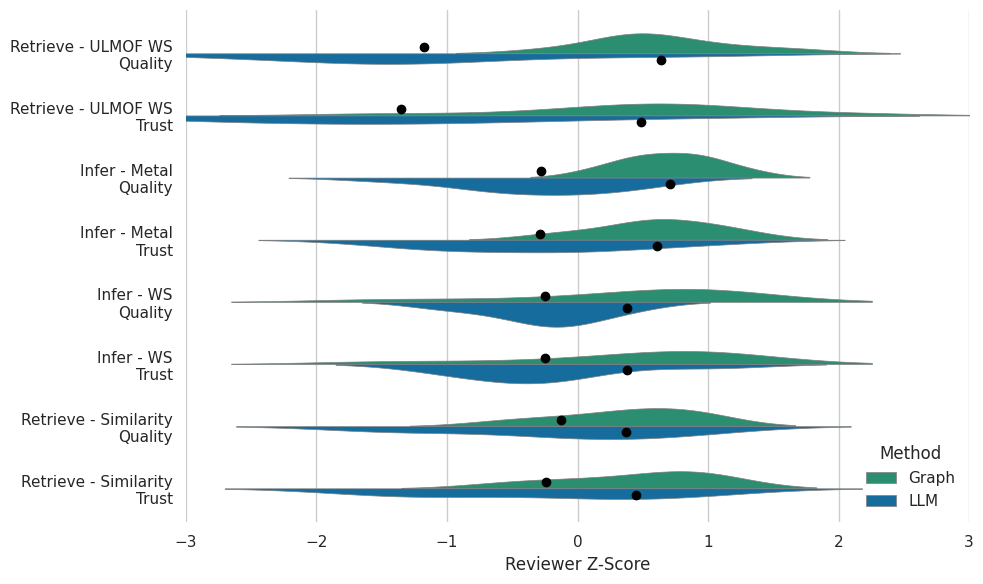

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt z_df into long format
z_long = z_df.melt(id_vars=["Reviewer"], var_name="Question_Model", value_name="Z")
z_long[["QID", "Metric", "Method"]] = z_long["Question_Model"].str.split("_", expand=True)

# Task mapping
task_lookup = {
    "Q1": "Retrieve - ULMOF WS",
    "Q2": "Infer - Metal",
    "Q3": "Infer - WS",
    "Q4": "Retrieve - Similarity",
}
z_long["Task"] = z_long["QID"].map(task_lookup)

# Create full label for grouping
z_long["Label"] = z_long["Task"] + "\n" + z_long["Metric"]

# Order the labels
label_order = [
    "Retrieve - ULMOF WS\nQuality", "Retrieve - ULMOF WS\nTrust",
    "Infer - Metal\nQuality", "Infer - Metal\nTrust",
    "Infer - WS\nQuality", "Infer - WS\nTrust",
    "Retrieve - Similarity\nQuality", "Retrieve - Similarity\nTrust"
]
z_long["Label"] = pd.Categorical(z_long["Label"], categories=label_order, ordered=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=z_long,
    x="Z",
    y="Label",
    hue="Method",
    split=True,
    inner=None,  # remove quartiles
    linewidth=0.5,
    edgecolor="gray",
    palette={"LLM": "#0072B2", "Graph": "#1B9E77"},
    ax=ax
)

# Add big mean markers
for _, row in means.iterrows():
    ypos = label_order.index(row["Label"]) + offset[row["Method"]]
    ax.plot(row["Z"], ypos, marker='o', color='black', markersize=6)

ax.set_xlim(-3, 3)


# Mean dots (optional overlay)
means = z_long.groupby(["Label", "Method"])["Z"].mean().reset_index()
offset = {"LLM": -0.1, "Graph": 0.1}
for _, row in means.iterrows():
    ypos = label_order.index(row["Label"]) + offset[row["Method"]]
    ax.plot(row["Z"], ypos, 'o', color='black', markersize=4)

# Formatting
ax.set_xlabel("Reviewer Z-Score", fontsize=12)
ax.set_ylabel("")
ax.legend(title="Method", frameon=False, loc="lower right")
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
fig.savefig("split_violin_zscores.svg", format="svg", bbox_inches="tight")


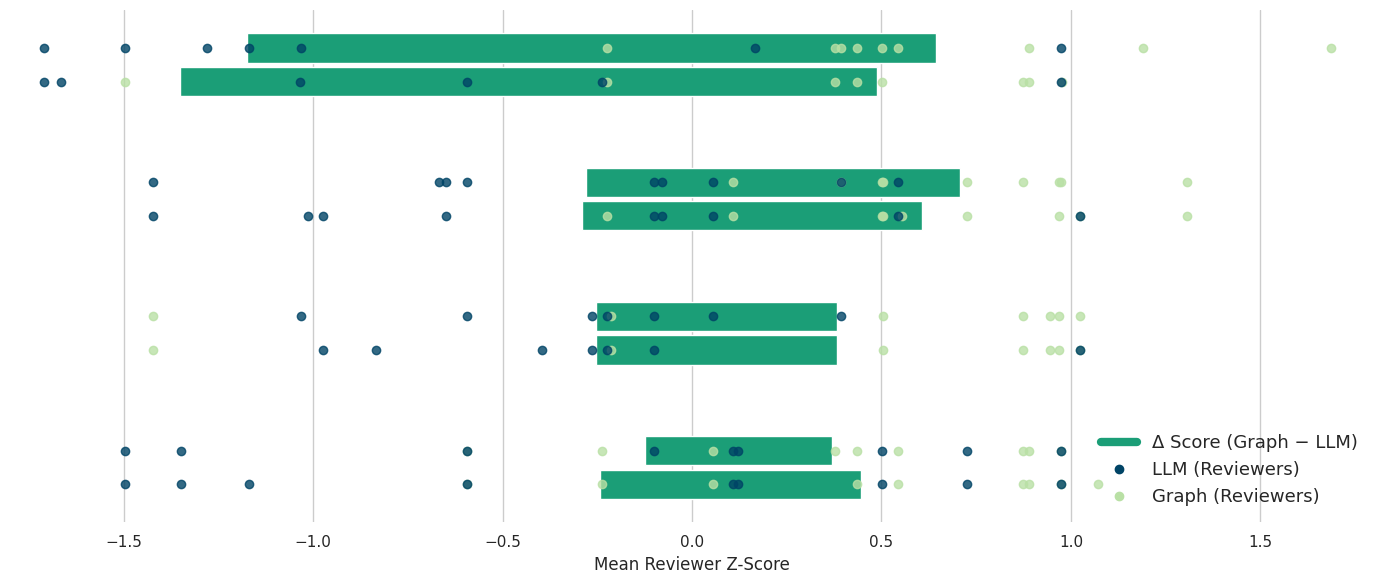

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1) Prep
tmp = mean_df.copy()
tmp[["QID", "Metric", "Method"]] = tmp["Question_Model"].str.split("_", expand=True)
task_lookup = {
    "Q1": "Retrieve - ULMOF WS",
    "Q2": "Infer - Metal",
    "Q3": "Infer - WS",
    "Q4": "Retrieve - Similarity",
}
tmp["Task"] = tmp["QID"].map(task_lookup)
tmp["Mean_z"] = mean_df["Mean_z"]
pivot = tmp.pivot_table(index=["Task", "Metric"], columns="Method", values="Mean_z")

# Melt z_df for scatter dots
z_long = z_df.melt(id_vars=["Reviewer"], var_name="Question_Model", value_name="Z")
z_long[["QID", "Metric", "Method"]] = z_long["Question_Model"].str.split("_", expand=True)
z_long["Task"] = z_long["QID"].map(task_lookup)

# 2) Layout
task_order   = ["Retrieve - ULMOF WS", "Infer - Metal", "Infer - WS", "Retrieve - Similarity"]
metric_order = ["Quality", "Trust"]
bar_h, within_gap, between_gap = .35, .05, .80
green = "#1B9E77"
dot_blue = "#B9E0A5"
dot_red = "#004466"
dot_size = 6

labels, yvals, start_vals, widths, dot_coords = [], [], [], [], []
y = 0
for task in task_order:
    for metric in metric_order:
        if (task, metric) in pivot.index:
            labels.append(f"{task} | {metric}")
            yvals.append(y)

            llm_val = pivot.loc[(task, metric), "LLM"]
            graph_val = pivot.loc[(task, metric), "Graph"]
            start = min(llm_val, graph_val)
            width = abs(graph_val - llm_val)
            start_vals.append(start)
            widths.append(width)

            # Scatter dots
            dots_graph = z_long.query("Task == @task and Metric == @metric and Method == 'Graph'")
            dots_llm   = z_long.query("Task == @task and Metric == @metric and Method == 'LLM'")
            for _, row in dots_graph.iterrows():
                dot_coords.append((row["Z"], y, dot_blue))
            for _, row in dots_llm.iterrows():
                dot_coords.append((row["Z"], y, dot_red))

            y += bar_h + within_gap
    y += between_gap

# 3) Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Delta bars
for y0, start, width in zip(yvals, start_vals, widths):
    ax.barh(y0, width, height=bar_h, left=start, color=green)

# Reviewer scatter dots
for x, y0, c in dot_coords:
    ax.plot(x, y0, 'o', color=c, markersize=dot_size, alpha=0.8)

# 4) Formatting
ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(left=False)
ax.set_xlabel("Mean Reviewer Z-Score", fontsize=12)
ax.set_xlim(-1.8, 1.8)
ax.invert_yaxis()
sns.despine(left=True, bottom=True)

# 5) Legend
ax.legend(
    handles=[
        Line2D([0], [0], lw=6, color=green, label="Δ Score (Graph − LLM)"),
        Line2D([0], [0], marker='o', color=dot_red, lw=0, label="LLM (Reviewers)"),
        Line2D([0], [0], marker='o', color=dot_blue, lw=0, label="Graph (Reviewers)"),
    ],
    frameon=False,
    loc="lower right",
    fontsize=13
)

plt.tight_layout()
plt.show()
# fig.savefig("delta_span_with_scatter.svg", format="svg", bbox_inches="tight")


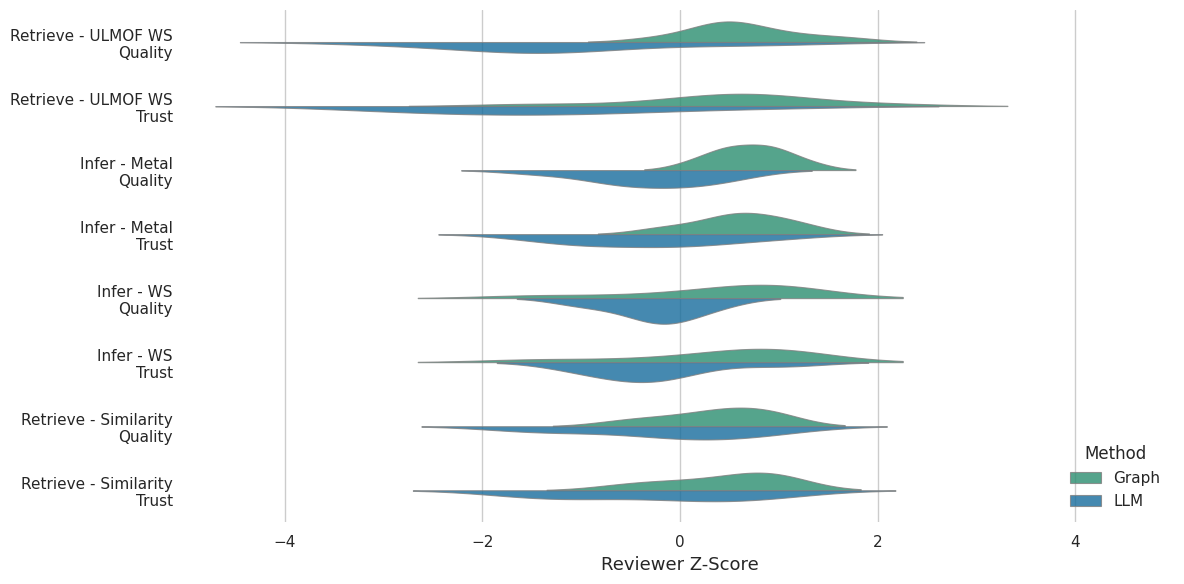

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt to long format
z_long = z_df.melt(id_vars=["Reviewer"], var_name="Question_Model", value_name="Z")
z_long[["QID", "Metric", "Method"]] = z_long["Question_Model"].str.split("_", expand=True)

# Task label mapping
task_lookup = {
    "Q1": "Retrieve - ULMOF WS",
    "Q2": "Infer - Metal",
    "Q3": "Infer - WS",
    "Q4": "Retrieve - Similarity",
}
z_long["Task"] = z_long["QID"].map(task_lookup)
z_long["Label"] = z_long["Task"] + "\n" + z_long["Metric"]

# Ordered labels
label_order = [
    "Retrieve - ULMOF WS\nQuality", "Retrieve - ULMOF WS\nTrust",
    "Infer - Metal\nQuality", "Infer - Metal\nTrust",
    "Infer - WS\nQuality", "Infer - WS\nTrust",
    "Retrieve - Similarity\nQuality", "Retrieve - Similarity\nTrust"
]
z_long["Label"] = pd.Categorical(z_long["Label"], categories=label_order, ordered=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(
    data=z_long,
    x="Z",
    y="Label",
    hue="Method",
    split=True,
    inner=None,
    linewidth=0.8,
    edgecolor="gray",
    palette={"LLM": "#0072B2", "Graph": "#1B9E77"},
    ax=ax,
    alpha=0.8
)

# Axis limits and labels
ax.set_xlim(-5, 5)
ax.set_xlabel("Reviewer Z-Score", fontsize=13)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=11)

# Legend styling
ax.legend(title="Method", frameon=False, loc="lower right", fontsize=11, title_fontsize=12)

# Remove axis spines
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
fig.savefig("split_violin_zscores_pretty.svg", format="svg", bbox_inches="tight")


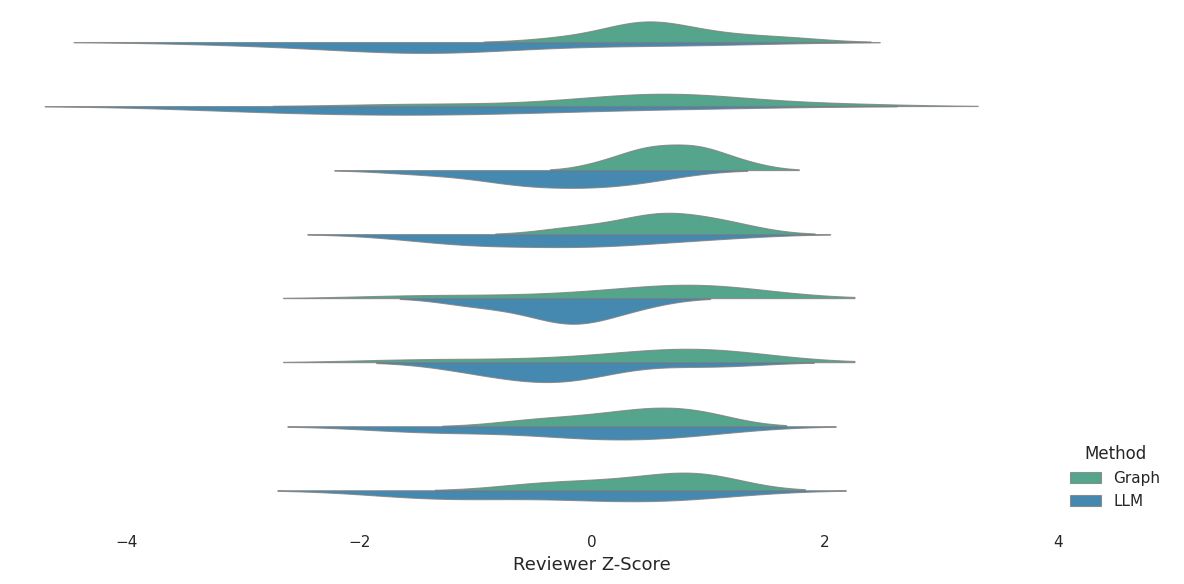

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt to long format
z_long = z_df.melt(id_vars=["Reviewer"], var_name="Question_Model", value_name="Z")
z_long[["QID", "Metric", "Method"]] = z_long["Question_Model"].str.split("_", expand=True)

# Task label mapping
task_lookup = {
    "Q1": "Retrieve - ULMOF WS",
    "Q2": "Infer - Metal",
    "Q3": "Infer - WS",
    "Q4": "Retrieve - Similarity",
}
z_long["Task"] = z_long["QID"].map(task_lookup)
z_long["Label"] = z_long["Task"] + "\n" + z_long["Metric"]

# Ordered labels
label_order = [
    "Retrieve - ULMOF WS\nQuality", "Retrieve - ULMOF WS\nTrust",
    "Infer - Metal\nQuality", "Infer - Metal\nTrust",
    "Infer - WS\nQuality", "Infer - WS\nTrust",
    "Retrieve - Similarity\nQuality", "Retrieve - Similarity\nTrust"
]
z_long["Label"] = pd.Categorical(z_long["Label"], categories=label_order, ordered=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(
    data=z_long,
    x="Z",
    y="Label",
    hue="Method",
    split=True,
    inner=None,
    linewidth=0.8,
    edgecolor="gray",
    palette={"LLM": "#0072B2", "Graph": "#1B9E77"},
    ax=ax,
    alpha=0.8
)

# Axis limits and labels
ax.set_xlim(-5, 5)
ax.set_xlabel("Reviewer Z-Score", fontsize=13)

# Remove y-axis labels and ticks
ax.set_ylabel("")
ax.set_yticks([])
ax.tick_params(axis='y', left=False)

# Remove grid and spines
ax.grid(False)
sns.despine(left=True, bottom=True)

# Legend styling
ax.legend(title="Method", frameon=False, loc="lower right", fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig("split_violin_zscores_clean.svg", format="svg", bbox_inches="tight")
